# Week 2. Case 1 (drafty notes)
Cognitive Systems for Health Technology Applications<br>
24.1.2019, Sakari Lukkarinen<br>
Helsinki Metropolia University of Applied Sciences

## Quick Guide
Here are all commands in one code cell for quick reference. Contains:

- Import libraries
- Import data
- Preprocess data and labels
- Building, compiling and training the model
- Visualizing the training results
- Calculating confusion matrix and best guess

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


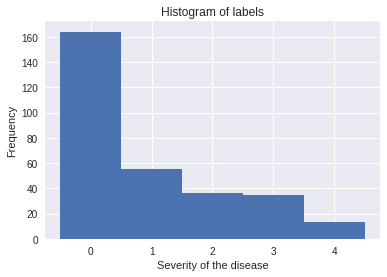

Shape of data and one-hot-labels: (303, 13) (303, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 126       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Elapsed time: 1.77 seconds


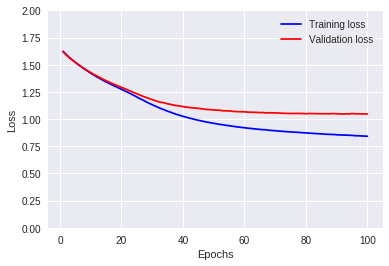

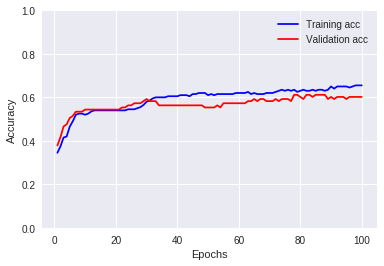

Best guess: 0.5413
Total accuracy: 0.6337
Confusion matrix:
[[154   7   0   3   0]
 [ 27  16   1  11   0]
 [  8   8   1  19   0]
 [  4  10   0  21   0]
 [  0   6   0   7   0]]
Support:
 [164  55  36  35  13]
Precision: [ 0.798  0.340  0.500  0.344  0.000]
Recall:    [ 0.939  0.291  0.028  0.600  0.000]
F-score:   [ 0.863  0.314  0.053  0.437  0.000]


In [1]:
# Import libraries
%pylab inline
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras import models, layers

# Import data
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
dataframe = pd.read_csv(url, 
                        sep = ',', 
                        header = None, 
                        index_col = None,
                        na_values = '?')

# Add column names
name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']
dataframe.columns = name_list

# Fill missing data with columnwise median values
dataframe = dataframe.fillna(dataframe.median())

# Randomize rows
dataframe = shuffle(dataframe)
dataframe.tail()

# Check the descriptive statistics
dataframe.describe()

# Select the data (input) columns
data_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal']
data = dataframe[data_list]

# Scale the data
data_min = data.min()
data_max = data.max()
data_norm = (data - data_min)/(data_max - data_min)

# Check descriptive statistics of normalized data
data_norm.describe()

# Select labels (output)
labels = dataframe['num']

# Plot the histogram of the labels (severity of the disease)
plt.hist(labels, bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('Severity of the disease')
plt.ylabel('Frequency')
plt.title('Histogram of labels')
show()

# Code labels to categorical output
one_hot_labels = to_categorical(labels)
one_hot_labels[:5]

# Check the shapes of the normalized data and categorical output
print('Shape of data and one-hot-labels:', data_norm.shape, one_hot_labels.shape)

# Split the data and labels into training and validation sets
train_data = data_norm[:200]
val_data = data_norm[200:]

train_labels = one_hot_labels[:200]
val_labels = one_hot_labels[200:]

# Build the model
model = models.Sequential()
model.add(layers.Dense(9, activation='relu', input_shape=(13,)))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

# Fit the model with the data and keep record on elapsed time
t_start = time.time()
history = model.fit(train_data, train_labels, 
                    epochs = 100, 
                    batch_size = 16, 
                    verbose = 0,
                    validation_data = (val_data, val_labels))
t_end = time.time()
print('Elapsed time: {:.2f} seconds'.format(t_end - t_start))

# Get the training data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

# Visualize the training process: loss function
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

# Visualize the accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Print total accuracy and confusion matrix
val_predicts = model.predict(data_norm)
y_pred = argmax(val_predicts, axis = 1)
cm = confusion_matrix(labels, y_pred)

# Best guess = Guess that all are normal
# ==> Normal cases are correctly classified
# Normal cases can be counted by summing all labels that are zeros
print('Best guess: {:.4f}'.format(np.sum(labels == 0)/len(labels)))

# Accuracy can be calculated from the confusion matrix by
# counting all elements in diagonal (=trace of the matrix)
print('Total accuracy: {:.4f}'.format(np.trace(cm)/sum(cm)))
print('Confusion matrix:')
print(cm)



# Calculate precision, recall, fscore and support
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(labels, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support:\n', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)

# We should do something in order to get the accuracy better, but what?

## Detailed explanations

### Import libraries
First we import all libraries (or modules) and functions needed in this session.

-  [`%pylab inline`](https://ipython.readthedocs.io/en/stable/interactive/magics.html#line-magics)  loads numpy and matplotlib modules
- [`import time`](https://duckduckgo.com/?q=python+time.time&t=ffab&atb=v150-2__&ia=about) we use for clocking the training evaluation time
- [`import warnings`](https://docs.python.org/2/library/warnings.html#temporarily-suppressing-warnings) is used for suppress warnings at the very end of the code
- `import pandas as pd` imports the pandas library and we can use the short notation `np`
-  `from sklearn ...` we import some special functions from scikit-learn module
- `from keras ...` is used for special keras functions

In [2]:
# Import libraries
%pylab inline
import time
import warnings
import pandas as pd

from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from keras.utils import to_categorical
from keras import models, layers

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shuffle', 'cm', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Import and preprocess data
Next we import the data using pandas [read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) function. 
- The file can be local or an url address to a file found from the Internet
- `sep = ','` tells that the comma is the column separator in the file
- `header = None` says that there are no headers (column titles) in the file
- `index_col = None` tells that we are not using any index columns, but pandas needs to generate the index itself
- `na_values` means that the missing values are marked with '?' - mark in the file

In [0]:
# Import data
url = r'http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
dataframe = pd.read_csv(url, 
                        sep = ',', 
                        header = None, 
                        index_col = None,
                        na_values = '?')


As the original file doesn't contain the column names we give the ourselves. The missing values are replaced with column-wise median-values. Another typical replacements are 0, mean-value, or random-value. Lastly we [shuffle](https://duckduckgo.com/?q=python+suffle&t=ffab&atb=v150-2__&ia=qa), e.g. change randomly the order of the rows.

The `dataframe.tail()` shows the first 5 rows of the data and [`dataframe.describe()`](https://duckduckgo.com/?q=pandas+describe&t=ffab&atb=v150-2__&ia=web) (see below) calculates the descriptive statistics.

In [4]:
# Add column names
name_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal','num']
dataframe.columns = name_list

# Fill missing data with columnwise median values
dataframe = dataframe.fillna(dataframe.median())

# Randomize rows
dataframe = shuffle(dataframe)
dataframe.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
49,53.0,1.0,3.0,130.0,197.0,1.0,2.0,152.0,0.0,1.2,3.0,0.0,3.0,0
214,52.0,1.0,4.0,112.0,230.0,0.0,0.0,160.0,0.0,0.0,1.0,1.0,3.0,1
295,41.0,1.0,2.0,120.0,157.0,0.0,0.0,182.0,0.0,0.0,1.0,0.0,3.0,0
204,43.0,1.0,4.0,110.0,211.0,0.0,0.0,161.0,0.0,0.0,1.0,0.0,7.0,0
110,61.0,0.0,4.0,145.0,307.0,0.0,2.0,146.0,1.0,1.0,2.0,0.0,7.0,1


In [5]:
# Check the descriptive statistics
dataframe.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal,num
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.663366,4.722772,0.937294
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.934375,1.938383,1.228536
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


The `dataframe` contains both the data (input) and the labels(output). Next we separate the input from the outputs and preprocess them. 

Usually the data columns have totally different scaling (see the descriptive statistics above). The neural networks usually wants the data be either normalized or scaled. Scikit-learn have [several options to preprocess the data](https://scikit-learn.org/stable/modules/preprocessing.html#). In this case we use simple min-max scaling and pandas own functions.

In [6]:
# Select the data (input) columns
data_list = ['age', 'sex', 'cp','trestbps', 'chol', 'fbs','restecg',
             'thalac','exang','oldpeak','slope','ca','thal']
data = dataframe[data_list]

# Scale the data
data_min = data.min()
data_max = data.max()
data_norm = (data - data_min)/(data_max - data_min)
                               
# Check descriptive statistics of normalized data
data_norm.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalac,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.529978,0.679868,0.719472,0.355564,0.275555,0.148515,0.495050,0.600055,0.326733,0.167678,0.300330,0.221122,0.430693
std,0.188305,0.467299,0.320042,0.166035,0.118212,0.356198,0.497486,0.174618,0.469794,0.187270,0.308113,0.311458,0.484596
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.395833,0.000000,0.666667,0.245283,0.194064,0.000000,0.000000,0.477099,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.562500,1.000000,0.666667,0.339623,0.262557,0.000000,0.500000,0.625954,0.000000,0.129032,0.500000,0.000000,0.000000
75%,0.666667,1.000000,1.000000,0.433962,0.340183,0.000000,1.000000,0.725191,1.000000,0.258065,0.500000,0.333333,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Next we want to preprocess the labels (output). As the outputs have several categories (from 0 to 4) we need to use keras `to_categorical` function to convert the integers into binary coded ([one hot](https://en.wikipedia.org/wiki/One-hot)) categories. The following code shows 
- how to pick the output column from the dataframe,
- plot the frequency histogram of the label values, and
- "one-hot" code the label categories

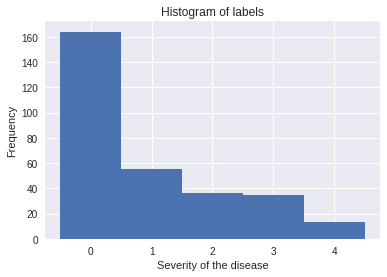

array([[ 0.000,  0.000,  0.000,  1.000,  0.000],
       [ 1.000,  0.000,  0.000,  0.000,  0.000],
       [ 0.000,  1.000,  0.000,  0.000,  0.000],
       [ 0.000,  0.000,  1.000,  0.000,  0.000],
       [ 0.000,  1.000,  0.000,  0.000,  0.000]], dtype=float32)

In [7]:
# Select labels (output)
labels = dataframe['num']

# Plot the histogram of the labels (severity of the disease)
plt.hist(labels, bins = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5])
plt.xlabel('Severity of the disease')
plt.ylabel('Frequency')
plt.title('Histogram of labels')
show()

# Code labels to categorical output
one_hot_labels = to_categorical(labels)
one_hot_labels[:5]

Next we split the data to training and validation data. The first 200 rows are used for training and the rest for validation. Training-validation ratio is thus 200:103, roughly 2:1. 

In [8]:
# Split the data and labels into training and validation sets
train_data = data_norm[:200]
val_data = data_norm[200:]

train_labels = one_hot_labels[:200]
val_labels = one_hot_labels[200:]

# Check the shapes of the data
print('Shape of')
print('  full data:        ', data_norm.shape)
print('  train data:       ',train_data.shape)
print('  validation data:  ',val_data.shape)
print('  one-hot-labels:   ', one_hot_labels.shape)
print('  train labels:     ',train_labels.shape)
print('  validation labels:',val_labels.shape)

Shape of
  full data:         (303, 13)
  train data:        (200, 13)
  validation data:   (103, 13)
  one-hot-labels:    (303, 5)
  train labels:      (200, 5)
  validation labels: (103, 5)


### The model
The model is very simple sequential architecture with two layers of neurons. The input (13) is fully connected to 9 middle neurons, which are then connected to 5 output neurons. 

We use `adam` optimizer and standard `categorical_crossentropy` loss-function and `accuracy` metrics.

In [9]:
# Build the model
model = models.Sequential()
model.add(layers.Dense(9, activation='relu', input_shape=(13,)))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer = 'adam',
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 9)                 126       
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 50        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


### Training
In the training we run 100 epochs and use batch size of 16. We suppress all printing during the training (verbose = 0). The validation data is given separately.

Alternatively, you could give all data in data and labels and use [`validation_split = 0.33`](https://keras.io/models/sequential/#fit) to say that separate 33% of the data for validation.

In [10]:
# Fit the model with the data and keep record on elapsed time
t_start = time.time()
history = model.fit(train_data, train_labels, 
                    epochs = 100, 
                    batch_size = 16, 
                    verbose = 0,
                    validation_data = (val_data, val_labels))
t_end = time.time()
print('Elapsed time: {:.2f} seconds'.format(t_end - t_start))

Elapsed time: 1.89 seconds


The training history is stored into variable `history`. It contains a structure `history.history` and separate variables for training and validation loss and accuracies. We extract those variables from history-structure and give them separate names.

In addition, we create a ascending list of epochs for plotting purposes.

In [0]:
# Get the training data
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(loss_values) + 1)

### Results
Now we are ready to visualize the training results. First the loss-function and next the accuracy.

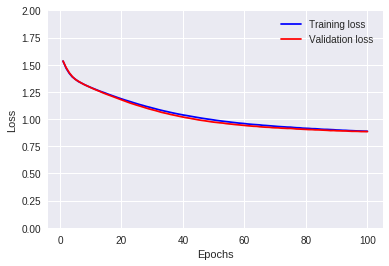

In [12]:
# Visualize the training process: loss function
plt.figure()
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend()
plt.show()

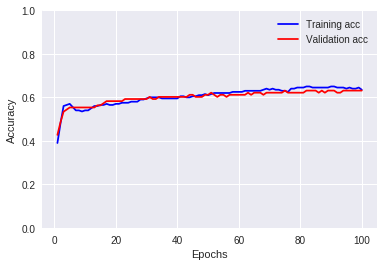

In [13]:
# Visualize the accuracy
plt.figure()
plt.plot(epochs, acc_values, 'b', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Confusion matrix
Lastly we calculate the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) results. 

Very simple classifier would classify all cases as normals (label = 0). However, we would make false predictions in all cases where 

In [14]:
# Print total accuracy and confusion matrix
val_predicts = model.predict(data_norm)
y_pred = argmax(val_predicts, axis = 1)

# Best guess = Guess that all are normal
simple_guess = zeros(len(y_pred))
cm0 = confusion_matrix(labels, simple_guess)
#Transpose the matrix if you want real values be in x-axis
#cm0 = np.transpose(cm0)
true0 = np.trace(cm0)
N = len(labels)
acc0 = true0/N
print('Simple guess accuracy: {:.4f}'.format(acc0))
print('Confusion matrix:')
print(cm0)

# Our model results
print(' ')
cm1 = confusion_matrix(labels, y_pred)
#cm1 = transpose(cm1)
true1 = np.trace(cm1)
N = len(labels)
acc1 = true1/N
print('Total accuracy: {:.4f}'.format(acc1))
print('Confusion matrix:')
print(cm1)

Simple guess accuracy: 0.5413
Confusion matrix:
[[164   0   0   0   0]
 [ 55   0   0   0   0]
 [ 36   0   0   0   0]
 [ 35   0   0   0   0]
 [ 13   0   0   0   0]]
 
Total accuracy: 0.6370
Confusion matrix:
[[156   3   3   2   0]
 [ 31   9   2  13   0]
 [  9   6   4  17   0]
 [  7   3   1  24   0]
 [  0   7   0   6   0]]


### More metrics
Lastly we calculate [more metrics from the confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix)

See also: [Model evaluation: Precision, recall, and F-measures](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

In [15]:
# Calculate precision, recall, fscore and support
# Suppress warnings as the f-score is zero
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p, r, f, s = precision_recall_fscore_support(labels, y_pred)

# Print precision, recall, fscore and support  
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
print('Support:\n', s)
print('Precision:', p)
print('Recall:   ', r)
print('F-score:  ', f)

Support:
 [164  55  36  35  13]
Precision: [ 0.768  0.321  0.400  0.387  0.000]
Recall:    [ 0.951  0.164  0.111  0.686  0.000]
F-score:   [ 0.850  0.217  0.174  0.495  0.000]


### Conclusions
We should do something in order to get the results better, but what?